In [48]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns

In [49]:
import tensorflow as tf

from tensorflow import keras
from keras import layers, models

print(tf.__version__)

2.8.2


In [50]:
# Ocitavanje kategorija
column_names_categories = ['code','parent-code','name']
categories_data = pd.read_csv('categories.csv', names = column_names_categories, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)
categories_data.head()

,code,parent-code,name
0,0,A,Other
1,1,B,Other
2,2,B,Auto Insurance
3,3,B,Auto Leasing
4,4,B,Gas & Fuel


In [51]:
# Ocitavanje mcc kodova
column_names_mmc = ['code', 'merchant-type']
mcc_data = pd.read_csv('mmc_codes.csv', names = column_names_mmc, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)
mcc_data.head()

,code,merchant-type
0,4814,Telecommunication service including local and ...
1,4815,VisaPhone
2,4821,Telegraph services
3,4829,Money Orders - Wire Transfer
4,4899,Cable and other pay television (previously Cab...


In [54]:
def preproccess_data(data_url, labels_url):
  column_names_data = ['id', 'beneficiary-name', 'date', 'direction', 'amount', 'description', 'currency', 'mcc', 'kind']
  dataset = pd.read_csv(data_url, names = column_names_data, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)

  column_names_labels = ['id', 'label']
  labels = pd.read_csv(labels_url, names = column_names_labels, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)

  dataset = pd.merge(dataset, labels, how='inner', on = 'id')  
 
  #amount
  dataset['amount'] = dataset['amount'].map(lambda x : float(str(x).replace(",", "")))
  
  #date => day, month, year

  days = [str(i) + "d" for i in range(1, 32)]
  months = [str(i) + "m" for i in range(1, 13)]

  dataset[["month", "day", "year"]] = dataset["date"].str.split("/", expand=True)
  del dataset['date']
  del dataset['year']
  
  dataset['day'] = dataset['day'].map(lambda x : x + "d")
  dataset['month'] = dataset['month'].map(lambda x : x + "m")

  # handle days as categorical
  unique_days_columns = dataset['day'].unique()

  days_dummy = pd.get_dummies(dataset['day'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, days_dummy], axis=1, join='inner')

  missing_columns_days = set(days) - set(unique_days_columns)
  values = [[0 for i in range(len(missing_columns_days))] for i in range(dataset.shape[0])]
  missing_df_days = pd.DataFrame(values, columns=missing_columns_days)

  dataset = pd.concat([dataset, missing_df_days], axis = 1, join='inner')
  del dataset['day']

  # handle months as categorical

  unique_months_columns = dataset['month'].unique()

  months_dummy = pd.get_dummies(dataset['month'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, months_dummy], axis=1, join='inner')

  missing_columns_months = set(months) - set(unique_months_columns)
  values = [[0 for i in range(len(missing_columns_months))] for i in range(dataset.shape[0])]
  missing_df_months = pd.DataFrame(values, columns=missing_columns_months)

  dataset = pd.concat([dataset, missing_df_months], axis = 1, join='inner')
  del dataset['month']

  #kind
  kinds = ['dep', 'wdw', 'pmt', 'fee', 'inc', 'rev', 'adj', 'lnd', 'lnr', 'fcx', 'aop', 'acl', 'spl', 'sal']
  
  # check nan values
  dataset['kind'] = dataset['kind'].fillna('U')

  # unique columns of given data (can be subset of all kinds)
  unique_kinds_columns = dataset['kind'].unique()
  
  # get dummies
  kind_dummy = pd.get_dummies(dataset['kind'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, kind_dummy], axis=1, join='inner')

  # handle missing columns from kinds
  missing_columns_kinds = set(kinds) - set(unique_kinds_columns)
  missing_columns_kinds = [str(x) for x in missing_columns_kinds]
  values = [[0 for i in range(len(missing_columns_kinds))] for i in range(dataset.shape[0])]
  missing_df_kinds = pd.DataFrame(values, columns=missing_columns_kinds)

  dataset = pd.concat([dataset, missing_df_kinds], axis = 1, join='inner')

  del dataset['kind']

  #direction
  direction_dummy = pd.get_dummies(dataset['direction'], prefix='', prefix_sep='')
  del dataset['direction']
  dataset = pd.concat([dataset, direction_dummy], axis=1, join='inner')


  # mcc
  
  # fill nan values & convert to int
  dataset['mcc'] = dataset['mcc'].fillna('0')
  dataset = dataset.astype({"mcc" : int})

  unique_columns_mcc = dataset['mcc'].unique()
  
  # get dummies
  mcc_dummy = pd.get_dummies(dataset['mcc'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, mcc_dummy], axis=1, join='inner')

  # handle missing values from mcc codes
  mcc_data['code'] = mcc_data['code'].astype({"code" : int}) 
  missing_columns_mcc = set(mcc_data['code']) - set(unique_columns_mcc)
  missing_columns_mcc = [str(x) for x in missing_columns_mcc]
  values = [[0 for i in range(len(missing_columns_mcc))] for i in range(dataset.shape[0])]
  missing_df_mcc = pd.DataFrame(values, columns=missing_columns_mcc)

  dataset = pd.concat([dataset, missing_df_mcc], axis = 1, join='inner')
  del dataset['mcc']

  # description
  del dataset['description']
  
  # beneficiary name
  del dataset['beneficiary-name']
  
  # currency
  del dataset['currency']
  
  # id
  del dataset['id']
  
  # IMPORTANT
  dataset = dataset.reindex(sorted(dataset.columns), axis=1)
  return dataset

In [55]:
dataset = preproccess_data("transactions.csv", "train_labels.csv")
dataset.shape

(1303, 314)

In [56]:
X = dataset.drop('label', axis = 1)
y = dataset[['label']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [57]:
def build_model(dataset):
  # TODO , nije lepo numerisano
  # num_classes = 107 
  num_classes = categories_data['code'].max() + 1
  num_parameters = dataset.shape[1] - 1

  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_dim= num_parameters))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax'))

  optimizer = tf.keras.optimizers.Adam()

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = optimizer,
                metrics=['accuracy'])
  return model

In [58]:
model = build_model(dataset)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                20096     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dense_15 (Dense)            (None, 107)               27499     
                                                                 
Total params: 88,939
Trainable params: 88,939
Non-trai

In [59]:
# checkpoint
! mkdir models

checkpoint_filepath = '/content/models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

mkdir: cannot create directory ‘models’: File exists


In [60]:
num_classes = categories_data['code'].max() + 1
epochs = 500
batch_size = 64

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 25)

train_labels_cat = tf.keras.utils.to_categorical(y_train, num_classes)
test_labels_cat = tf.keras.utils.to_categorical(y_test, num_classes)


# add batch size
history = model.fit(X_train, train_labels_cat, epochs = epochs, batch_size = batch_size, validation_split = 0.2, callbacks=[early_stop, model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/500
13/13 [==============================] - 1s 22ms/step - loss: 7.6934 - accuracy: 0.0499 - val_loss: 4.6805 - val_accuracy: 0.2245
Epoch 2/500
13/13 [==============================] - 0s 7ms/step - loss: 5.2477 - accuracy: 0.0819 - val_loss: 4.4789 - val_accuracy: 0.0561
Epoch 3/500
13/13 [==============================] - 0s 7ms/step - loss: 5.3280 - accuracy: 0.0922 - val_loss: 4.3830 - val_accuracy: 0.1684
Epoch 4/500
13/13 [==============================] - 0s 7ms/step - loss: 4.6731 - accuracy: 0.2087 - val_loss: 4.2447 - val_accuracy: 0.3112
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 4.4654 - accuracy: 0.2638 - val_loss: 4.0448 - val_accuracy: 0.3112
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 4.1252 - accuracy: 0.2702 - val_loss: 3.9942 - val_accuracy: 0.3367
Epoch 7/500
13/13 [==============================] - 0s 9ms/step - loss: 3.9613 - accuracy: 0.2817 - val_loss: 3.4967 - val_accuracy: 0.3469
Epoch 8/500


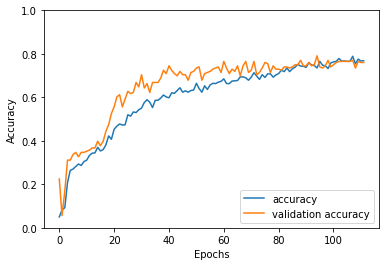

In [61]:
# Evaluation

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [62]:
test_loss, test_acc = model.evaluate(X_test, test_labels_cat, verbose=2)

11/11 - 0s - loss: 0.7640 - accuracy: 0.7577 - 40ms/epoch - 4ms/step


In [63]:
model = build_model(dataset)

early_stop_epochs = 112

mid_history = model.fit(X_train, train_labels_cat, epochs=early_stop_epochs)

Epoch 1/112
31/31 [==============================] - 1s 6ms/step - loss: 6.5773 - accuracy: 0.0614
Epoch 2/112
31/31 [==============================] - 0s 5ms/step - loss: 5.2112 - accuracy: 0.1177
Epoch 3/112
31/31 [==============================] - 0s 5ms/step - loss: 4.8786 - accuracy: 0.2446
Epoch 4/112
31/31 [==============================] - 0s 7ms/step - loss: 4.3459 - accuracy: 0.3040
Epoch 5/112
31/31 [==============================] - 0s 6ms/step - loss: 3.8492 - accuracy: 0.3101
Epoch 6/112
31/31 [==============================] - 0s 6ms/step - loss: 3.3324 - accuracy: 0.3142
Epoch 7/112
31/31 [==============================] - 0s 6ms/step - loss: 2.8187 - accuracy: 0.3449
Epoch 8/112
31/31 [==============================] - 0s 6ms/step - loss: 2.7392 - accuracy: 0.3501
Epoch 9/112
31/31 [==============================] - 0s 8ms/step - loss: 2.6176 - accuracy: 0.3644
Epoch 10/112
31/31 [==============================] - 0s 6ms/step - loss: 2.3769 - accuracy: 0.3859
Epoch 11/

In [64]:
test_loss, test_acc = model.evaluate(X_test, test_labels_cat, verbose=2)

11/11 - 0s - loss: 0.9210 - accuracy: 0.7423 - 162ms/epoch - 15ms/step


In [65]:
model = build_model(dataset)

early_stop_epochs = 112

y_cat = tf.keras.utils.to_categorical(y, num_classes)


final_history = model.fit(X, y_cat, epochs=early_stop_epochs)

Epoch 1/112
41/41 [==============================] - 1s 4ms/step - loss: 6.3608 - accuracy: 0.0906
Epoch 2/112
41/41 [==============================] - 0s 4ms/step - loss: 4.6744 - accuracy: 0.1995
Epoch 3/112
41/41 [==============================] - 0s 4ms/step - loss: 4.1132 - accuracy: 0.2771
Epoch 4/112
41/41 [==============================] - 0s 4ms/step - loss: 3.3324 - accuracy: 0.3116
Epoch 5/112
41/41 [==============================] - 0s 4ms/step - loss: 2.9372 - accuracy: 0.3231
Epoch 6/112
41/41 [==============================] - 0s 4ms/step - loss: 2.6206 - accuracy: 0.3354
Epoch 7/112
41/41 [==============================] - 0s 4ms/step - loss: 2.4139 - accuracy: 0.3661
Epoch 8/112
41/41 [==============================] - 0s 4ms/step - loss: 2.2132 - accuracy: 0.4175
Epoch 9/112
41/41 [==============================] - 0s 4ms/step - loss: 1.9771 - accuracy: 0.4536
Epoch 10/112
41/41 [==============================] - 0s 4ms/step - loss: 1.8490 - accuracy: 0.5058
Epoch 11/

In [66]:
model_path = 'models/categories_network.h5'
model.save(model_path)

! ls models

categories_network.h5


In [67]:
model = None
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                20096     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               33024     
                                                                 
 dense_23 (Dense)            (None, 107)               27499     
                                                                 
Total params: 88,939
Trainable params: 88,939
Non-trai

In [68]:
test_dataset = preproccess_data("transactions.csv", "test_labels.csv")
test_dataset.shape

(200, 314)

In [69]:
X = test_dataset.drop('label', axis=1)
y_test = test_dataset[['label']]

y_cat = tf.keras.utils.to_categorical(y_test, num_classes)

test_loss, test_acc = model.evaluate(X, y_cat, verbose=2)

7/7 - 0s - loss: 0.2565 - accuracy: 0.9200 - 150ms/epoch - 21ms/step
